In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import albumentations as A
from sklearn.model_selection import train_test_split

OSError: [WinError 127] Die angegebene Prozedur wurde nicht gefunden. Error loading "C:\Users\ve59kedo\.conda\envs\HUNet\lib\site-packages\torch\lib\nvfuser_codegen.dll" or one of its dependencies.

In [2]:
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/Tiles_0.6_256_64'
tile_size1 = (256,256)
tile_size2 = (256,256,1)
input_shape = (256,256,3)
tile_type = 'Tiles_2.0_512_256'

 
x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))

    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)


In [3]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 28448 samples
Validation set: 12193 samples
Test set: 411 samples


In [4]:
for i in range(len(Y_train)):
    
    lbl_arr = Image.open(Y_train[i])
    lbl_arr = lbl_arr.resize((256, 256))
    lbl_arr = np.array(lbl_arr)
    if len(np.unique(lbl_arr))>3:
        print(np.shape(lbl_arr),np.unique(lbl_arr))
        #plt.imshow(lbl_arr)
        break

(256, 256) [0 1 2 5]


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True):
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = [
            'background',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Bindegewebe',
            'X2 Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel längss',
            'Nerv']
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(1, 13, 1)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        X_tensor = torch.stack([F.to_tensor(x) for x in X])
        y_tensor = torch.stack([torch.from_numpy(y_item).permute(2, 0, 1) for y_item in y])

        return X_tensor, y_tensor

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        x_images = []
        y_images = []

        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            img_arr = Image.open(sample_path)
            img_arr = img_arr.resize(tile_size1)
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))

            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize(tile_size1)
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 12), dtype=np.float32)
            bg = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1]))

            for i, value in enumerate(self.unique):
                channels[:, :, i] = (lbl_arr == value).astype(np.uint8) * 255

            bg = (lbl_arr == 0).astype(np.uint8) * 255
            bg = np.reshape(bg, tile_size2)
            lbl_arr = channels
            lbl_arr = np.concatenate((bg, lbl_arr), axis=2)

            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        return x_images, y_images

    def viz(self, x_images, y_images):
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            fig, axs = plt.subplots(1, 14, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(1, 14):
                axs[i].imshow(y_mask[:, :, i - 1], cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'{self.class_names[i - 1]}')
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')


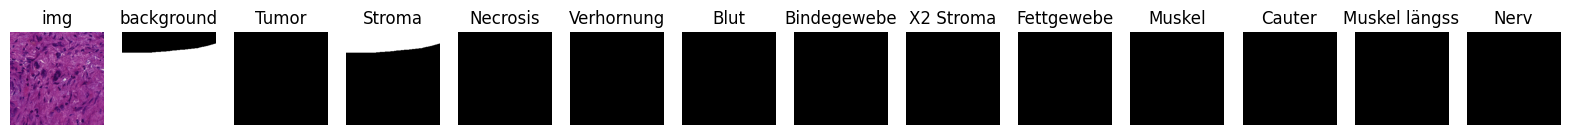

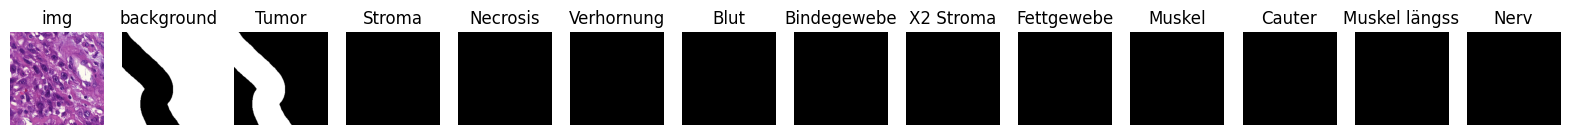

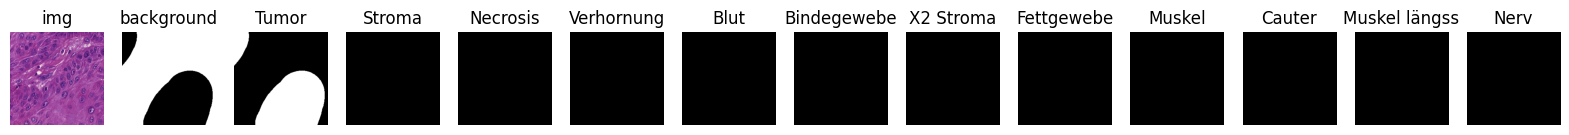

Batch shape (3, 256, 256, 3) and for masks (3, 256, 256, 13)
image shape (256, 256, 3) and for masks (256, 256, 13)
max value for images is 1.0 and for masks 1.0
min value for images is 0.01568627543747425 and for masks 0.0
number of unique values in images is 252 and for masks [0. 1.]


In [6]:
test = DataGenerator(x,y,batch_size=3,aug=0)
a,b = test.__getitem__(1)
test.viz(a,b)

In [12]:
from tensorflow.keras.layers import Add

fil = 32
inputs = Input(input_shape)

# Contractive
conv1 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv2 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv2 = BatchNormalization()(conv2)
skip1 = Add()([conv1, conv2])
pool1 = MaxPooling2D(pool_size=(2, 2))(skip1)

conv3 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv4 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv4 = BatchNormalization()(conv4)
skip2 = Add()([conv3, conv4])
pool2 = MaxPooling2D(pool_size=(2, 2))(skip2)

conv5 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv6 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv6 = BatchNormalization()(conv6)
skip3 = Add()([conv5, conv6])
pool3 = MaxPooling2D(pool_size=(2, 2))(skip3)

conv7 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv8 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv8 = BatchNormalization()(conv8)
skip4 = Add()([conv7, conv8])
pool4 = MaxPooling2D(pool_size=(2, 2))(skip4)

conv9 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv10 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = BatchNormalization()(conv10)
skip5 = Add()([conv9, conv10])


# Expansive
upconv1 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(skip5)
up6 = UpSampling2D(size=(2, 2))(upconv1)
merge6 = concatenate([skip4, up6], axis=3)
conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = UpSampling2D(size=(2, 2))(upconv2)
merge7 = concatenate([skip3, up7], axis=3)
conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(fil * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
up8 = UpSampling2D(size=(2, 2))(upconv3)
merge8 = concatenate([skip2, up8], axis=3)
conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upconv4 = Conv2D(fil * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
up9 = UpSampling2D(size=(2, 2))(upconv4)
merge9 = concatenate([skip1, up9], axis=3)
conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(13, 1, activation='softmax')(conv9)

model = Model(inputs=inputs, outputs=conv10)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [203]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: C:\Users\ve59kedo\.conda\envs\HUNet\python.exe -m pip install --upgrade pip


In [90]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()

def custom_Diceloss(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return loss(y_true_exclude_first, y_pred_exclude_first)

DiceLoss = DiceLoss()
IOUscore0 = IOUScore(class_indexes=0, name='BG')
IOUscore1 = IOUScore(class_indexes=1, name='IOU_Tumor')
IOUscore2 = IOUScore(class_indexes=2, name='IOU_Stroma')
IOUscore3 = IOUScore(class_indexes=3, name='IOU_Necrosis')
IOUscore4 = IOUScore(class_indexes=4, name='IOU_Verhornung')
IOUscore5 = IOUScore(class_indexes=5, name='IOU_Blut')
IOUscore6 = IOUScore(class_indexes=6, name='IOU_Lockeres_Bindegewebe')
IOUscore7 = IOUScore(class_indexes=7, name='IOU_Zellreiches_Stroma')
IOUscore8 = IOUScore(class_indexes=8, name='IOU_Fettgewebe')
IOUscore9 = IOUScore(class_indexes=9, name='IOU_Muskel')
IOUscore10 = IOUScore(class_indexes=10, name='IOU_Cauter')
IOUscore11 = IOUScore(class_indexes=11, name='IOU_Muskel_längss')
IOUscore12 = IOUScore(class_indexes=12, name='IOU_Nerv')


In [103]:
import tensorflow as tf
import keras.backend as K

def lovasz_softmax_loss(y_true, y_pred):
    """
    Calculates the Lovász-Softmax loss between predicted logits and ground truth targets.

    Args:
        y_true (tensorflow.Tensor): Ground truth segmentation maps. Shape (N, H, W, C),
                                   where N is the batch size, H, W are the height and width
                                   of the segmentation maps, and C is the number of classes.
        y_pred (tensorflow.Tensor): Predicted logits from the network. Shape (N, H, W, C),
                                   where N is the batch size, H, W are the height and width
                                   of the prediction maps, and C is the number of classes.

    Returns:
        tensorflow.Tensor: Lovász-Softmax loss.

    Reference:
    - B. B. Zhou et al., "Learning to Rank Objects," ECCV 2018.
    - https://github.com/bermanmaxim/LovaszSoftmax

    """
    
    # Flatten the logits and targets
    y_pred_flat = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))  # Shape: (N*H*W, C)
    y_true_flat = K.reshape(y_true, (-1, K.int_shape(y_true)[-1]))  # Shape: (N*H*W, C)

    # Calculate the Lovász-Softmax loss
    loss = lovasz_softmax(y_pred_flat, y_true_flat)
    
    return loss


def lovasz_softmax_loss(y_true, y_pred):
    """
    Calculates the Lovász-Softmax loss between predicted logits and ground truth targets.

    Args:
        y_true (tensorflow.Tensor): Ground truth segmentation maps. Shape (N, H, W, C),
                                   where N is the batch size, H, W are the height and width
                                   of the segmentation maps, and C is the number of classes.
        y_pred (tensorflow.Tensor): Predicted logits from the network. Shape (N, H, W, C),
                                   where N is the batch size, H, W are the height and width
                                   of the prediction maps, and C is the number of classes.

    Returns:
        tensorflow.Tensor: Lovász-Softmax loss.

    Reference:
    - B. B. Zhou et al., "Learning to Rank Objects," ECCV 2018.
    - https://github.com/bermanmaxim/LovaszSoftmax

    """
    
    # Flatten the logits and targets
    y_pred_flat = tf.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))  # Shape: (N*H*W, C)
    y_true_flat = tf.reshape(y_true, (-1, K.int_shape(y_pred)[-1]))  # Shape: (N*H*W, C)

    # Calculate the Lovász-Softmax loss
    loss = lovasz_softmax(y_pred_flat, y_true_flat)
    
    return loss


def lovasz_hinge(logits, targets):
    """
    Computes the Lovász hinge loss.

    Args:
        logits (tensorflow.Tensor): Predicted logits from the network. Shape (N, C),
                                    where N is the number of samples and C is the number of classes.
        targets (tensorflow.Tensor): Ground truth class labels. Shape (N, C).

    Returns:
        tensorflow.Tensor: Lovász hinge loss.

    Reference:
    - B. B. Zhou et al., "Learning to Rank Objects," ECCV 2018.
    - https://github.com/bermanmaxim/LovaszSoftmax

    """

    # Compute the binary Lovász hinge loss
    errors = targets - logits
    errors_sorted, perm = tf.nn.top_k(errors, k=K.shape(errors)[-1])
    perm_sorted = K.cast(perm, dtype=tf.int32)
    targets_sorted = tf.gather_nd(targets, tf.expand_dims(perm_sorted, axis=-1))
    grad = lovasz_grad(targets_sorted)
    loss = K.dot(K.relu(errors_sorted), K.transpose(grad))

    return loss


def lovasz_grad(targets_sorted):
    """
    Computes the gradient of the Lovász hinge loss.

    Args:
        targets_sorted (tensorflow.Tensor): Sorted ground truth class labels. Shape (N, C).

    Returns:
        tensorflow.Tensor: Gradient of the Lovász hinge loss.

    Reference:
    - B. B. Zhou et al., "Learning to Rank Objects," ECCV 2018.
    - https://github.com/bermanmaxim/LovaszSoftmax

    """

    sorted_indices = tf.range(K.shape(targets_sorted)[-1])
    grad = tf.zeros_like(targets_sorted, dtype=K.floatx())
    for i in sorted_indices:
        g = tf.constant(0.0, dtype=K.floatx())
        if i > 0:
            g += targets_sorted[:, i - 1]
        if i < K.shape(targets_sorted)[-1] - 1:
            g -= targets_sorted[:, i + 1]
        indices = tf.expand_dims(tf.stack([tf.range(tf.shape(targets_sorted)[0]), tf.fill([tf.shape(targets_sorted)[0]], i)], axis=1), axis=1)
        grad = tf.tensor_scatter_nd_update(grad, indices, g)

    return grad



In [1]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

# Define the learning rate scheduler function
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)

# Update the loss in model compilation
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False),
              loss=lovasz_softmax_loss,  # Updated loss function
              metrics=[
                  IOUscore0,
                  IOUscore1,
                  IOUscore2,
                  IOUscore3,
                  IOUscore4,
                  IOUscore5,
                  IOUscore6,
                  IOUscore7,
                  IOUscore8,
                  IOUscore9,
                  IOUscore10,
                  IOUscore11,
                  IOUscore12,
              ])

history = model.fit(DataGenerator(X_train, Y_train, batch_size=1, aug=1),
                    epochs=200,
                    validation_data=DataGenerator(X_val, Y_val, batch_size=1, aug=1),
                    callbacks=[reduce_lr]
                    )


NameError: name 'model' is not defined

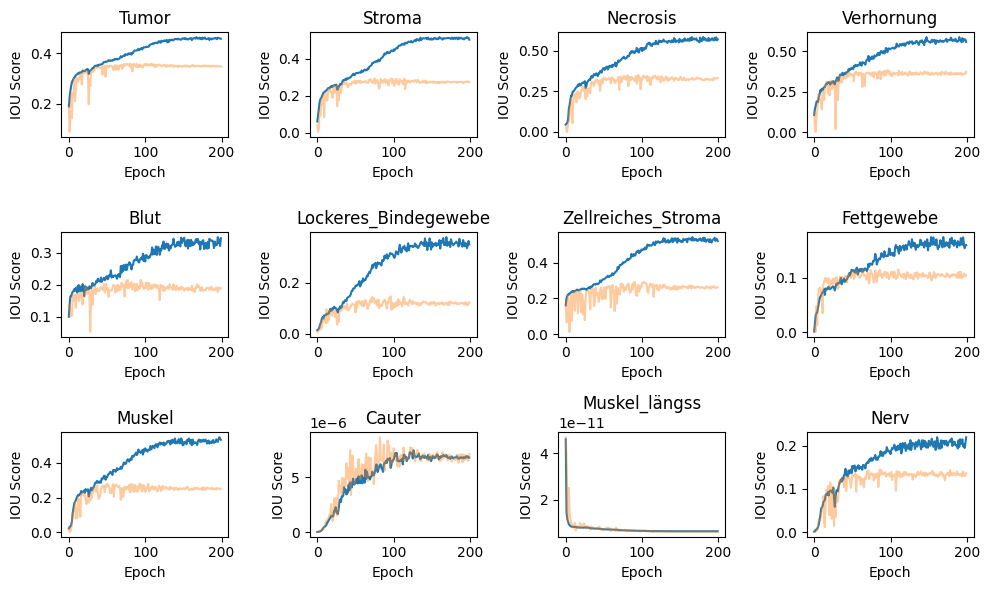

In [190]:
#how was the network on each epoch?

class_names = [
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längss',
            'Nerv']

fig, axes = plt.subplots(3, 4, figsize=(10, 6))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    metric_name = 'IOU_' + class_name
    val_name = 'val_IOU_' + class_name
    axes[i].plot(history.history[metric_name])
    axes[i].plot(history.history[val_name],alpha=0.4)
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('IOU Score')

# Hide unused subplots
for j in range(len(class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('./attempts/32SGDM_0.6.png') 

plt.show()

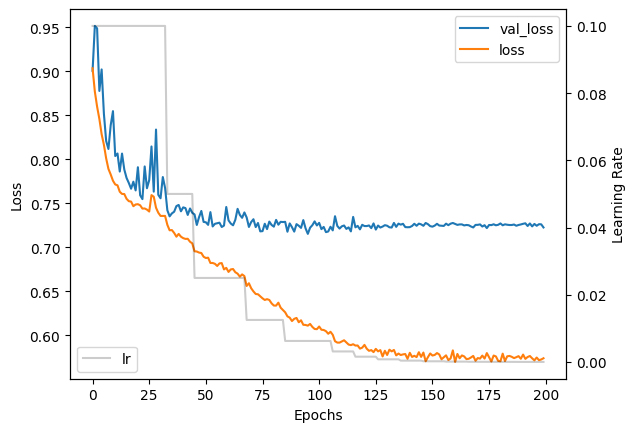

In [42]:
import matplotlib.pyplot as plt

# Create the figure and the first y-axis
fig, ax1 = plt.subplots()

# Plot the first dataset
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.plot(history.history['loss'], label='loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second dataset
ax2.plot(history.history['lr'], label='lr', color='black',alpha=0.2)
ax2.set_ylabel('Learning Rate')
ax2.legend(loc='lower left')

plt.savefig('./attempts/32SGDM_0.6.png') 
plt.show()


In [81]:
# Save the weights
model.save_weights('./weights/32SGDM_2.0_lr=0.1&50&lr=0.01_big_2')

In [43]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=True)
a, b =DataGen.__getitem__(0)
score = model.evaluate(a,b)


13/13 [==============================] - 3s 246ms/step - loss: 0.7190 - BG: 2.8438e-06 - IOU_Tumor: 0.3486 - IOU_Stroma: 0.2816 - IOU_Necrosis: 0.3501 - IOU_Verhornung: 0.3984 - IOU_Blut: 0.2515 - IOU_Lockeres_Bindegewebe: 0.1283 - IOU_Zellreiches_Stroma: 0.2485 - IOU_Fettgewebe: 0.0463 - IOU_Muskel: 0.1912 - IOU_Cauter: 6.9255e-06 - IOU_Muskel_längss: 6.5921e-12 - IOU_Nerv: 0.1728


In [168]:
class_names = [
    
            'BG',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längss',
            'Nerv']

1/1 [==============================] - 1s 981ms/step


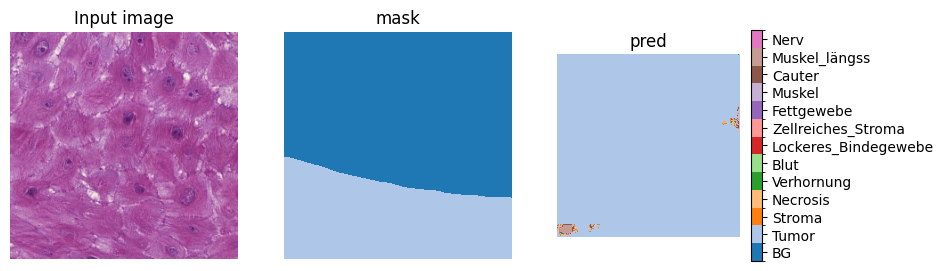

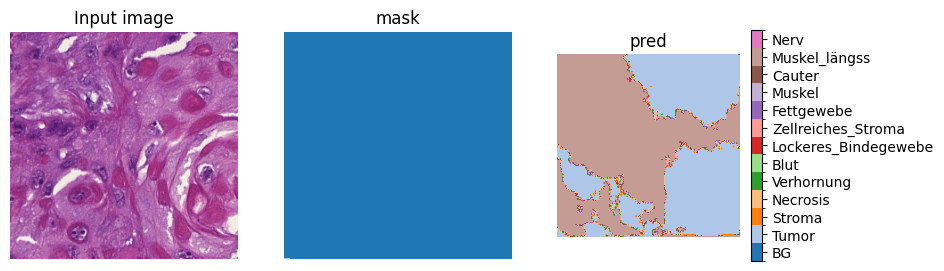

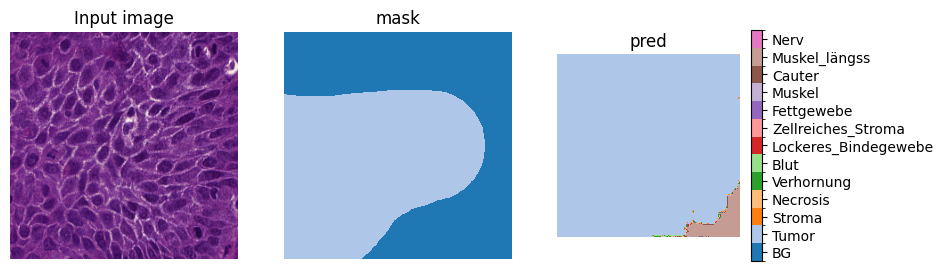

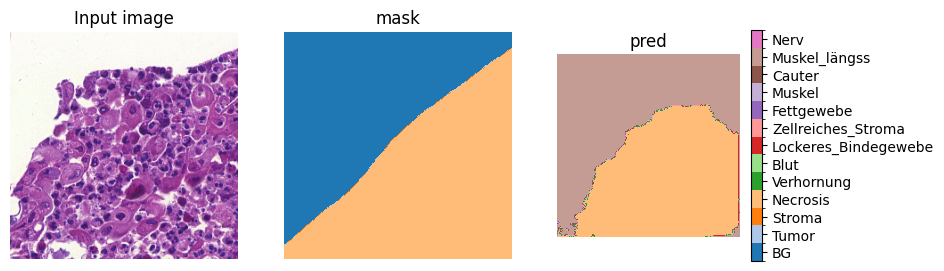

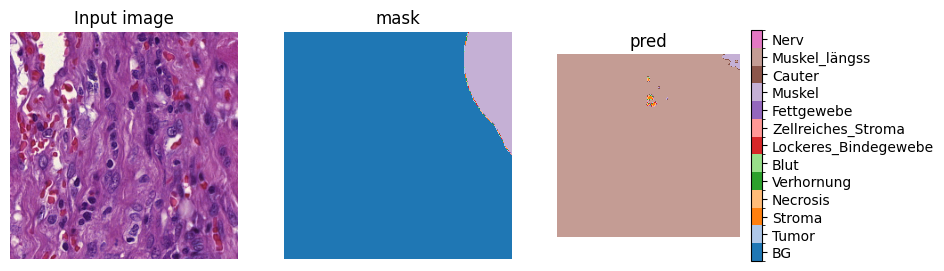

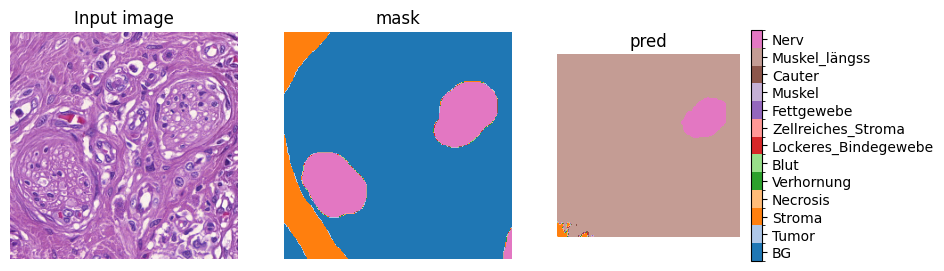

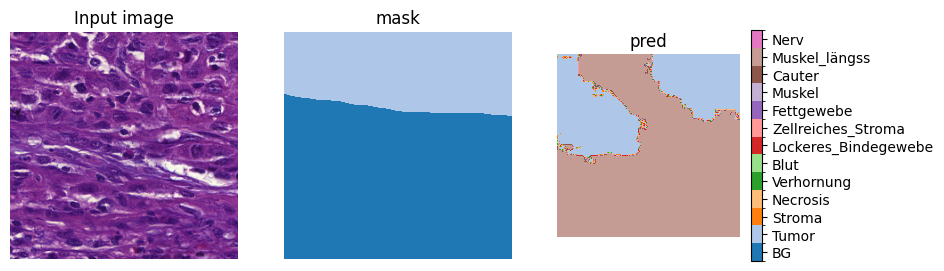

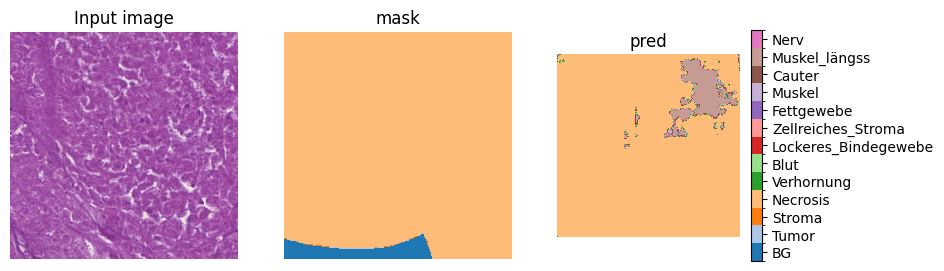

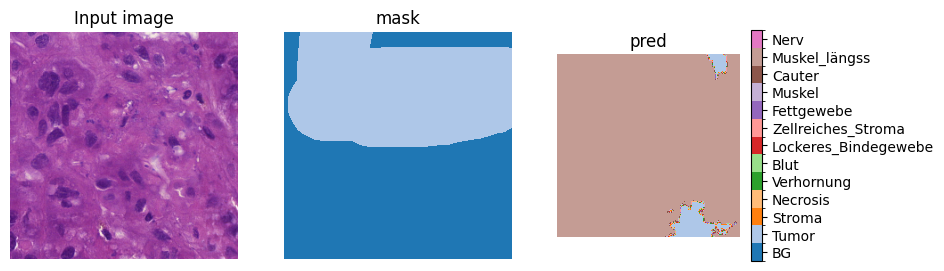

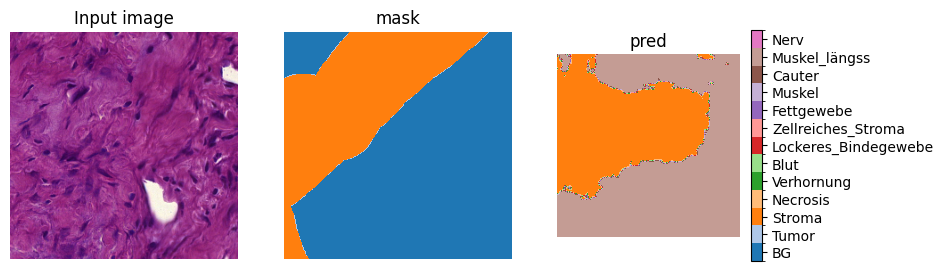

In [189]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Normal
DataGen = DataGenerator(X_test, Y_test, batch_size=10, aug=False)
img, mask = DataGen.__getitem__(0)
y_pred = model.predict(img)

for idx in range(np.shape(y_pred)[0]):
    # Create the figure and axis
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))

    # Plot the input image
    ax[0].imshow(img[idx])
    ax[0].set_title('Input image')
    ax[0].axis('off')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    for i in range(13):
        empty = empty + mask[idx][:, :, i] * i

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:13])
    bounds = np.arange(0, 14) - 0.5  # Set boundaries of color segments
    norm = BoundaryNorm(bounds, cmap.N)
    ax[1].axis('off')

    im = ax[1].imshow(empty, cmap=cmap, norm=norm)
    ax[1].set_title('mask')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    for i in range(13):
        empty = empty + y_pred[idx][:, :, i] * i

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:13])
    ax[2].axis('off')
    

    im = ax[2].imshow(empty, cmap=cmap, norm=norm)
    ax[2].set_title('pred')

    # Add colorbar next to the second plot
    cbar = plt.colorbar(im, ax=ax[2], ticks=np.arange(0, 13), shrink=0.3)
    cbar.set_ticklabels(class_names)

    plt.show()


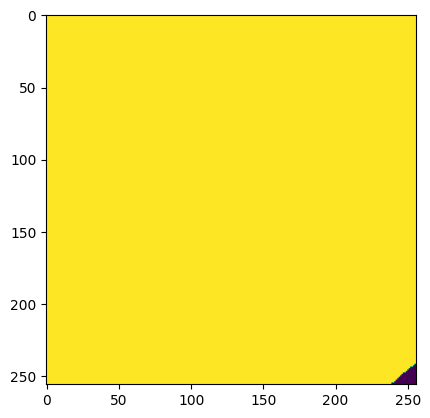